In [29]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr
from itertools import product
from sklearn.manifold import MDS
import pandas as pd

from scipy.io import loadmat
from numpy.linalg import lstsq
from scipy.stats import t

## Project Work 4: RSA of fMRI responses

## Load previous data necessary for this assignment

In [30]:
def create_design_matrix(labels):
    """
    Creates a design matrix from a labels DataFrame.

    Parameters:
        labels (pandas.DataFrame): A DataFrame containing 'Condition' and 'Run' columns.

    Returns:
        pandas.DataFrame: The design matrix with conditions as columns.
    """
    # Get unique conditions from labels
    unique_conditions = labels["Condition"].unique()

    # Initialize the design matrix
    design_matrix = pd.DataFrame(0, index=np.arange(len(labels)), columns=unique_conditions)

    # Fill the design matrix
    for condition in unique_conditions:
        design_matrix[condition] = (labels["Condition"] == condition).astype(int)

    # Drop the 'rest' condition
    if "rest" in design_matrix.columns:
        design_matrix = design_matrix.drop(columns=["rest"])
        #print("'rest' condition dropped from the design matrix.")

    return design_matrix

In [31]:
def add_run_intercepts(design_matrix, labels): 
    """
    Adds intercept columns for each run to the design matrix.

    Parameters:
        design_matrix (pd.DataFrame): Original design matrix (time points × conditions).
        labels (pd.DataFrame): DataFrame with 'Condition' and 'Run' columns.

    Returns:
        pd.DataFrame: Design matrix with added intercept columns.
    """
    design_matrix_with_intercepts = design_matrix.copy()
    unique_runs = labels["Run"].unique()

    # Add intercept columns
    for run in unique_runs:
        run_column_name = f"Run_{run}"
        design_matrix_with_intercepts[run_column_name] = (labels["Run"] == run).astype(int)

    return design_matrix_with_intercepts

In [32]:
def convolve_conditions(design_matrix, hrf_sampled):
    """
    Convolves only the condition columns of the design matrix with the HRF.

    Parameters:
        design_matrix (pd.DataFrame): Design matrix with conditions and intercepts.
        hrf_sampled (numpy.ndarray): The sampled HRF.

    Returns:
        pd.DataFrame: Design matrix with convolved conditions and unmodified intercepts.
    """
    # Identify condition columns (non-intercept)
    condition_columns = [col for col in design_matrix.columns if not col.startswith("Run")]
    intercept_columns = [col for col in design_matrix.columns if col.startswith("Run")]

    # Initialize the convolved matrix
    convolved_matrix = pd.DataFrame(index=design_matrix.index)

    # Convolve conditions
    for condition in condition_columns:
        convolved_signal = np.convolve(design_matrix[condition], hrf_sampled, mode="full")[:len(design_matrix)]
        convolved_matrix[condition] = convolved_signal

    # Add intercept columns without modification
    for intercept in intercept_columns:
        convolved_matrix[intercept] = design_matrix[intercept]

    return convolved_matrix

In [33]:
def fit_glm_and_generate_beta_maps(bold_data, X):
    """
    Fits a General Linear Model (GLM) voxel-by-voxel and generates beta coefficient maps.

    Parameters:
        bold_data (numpy.ndarray): The 4D BOLD fMRI data with shape (X, Y, Z, Time).
        X (pandas.DataFrame): The convolved design matrix.

    Returns:
        numpy.ndarray: Beta coefficient maps with shape (X, Y, Z, N_conditions).
    """
    # Reshape the fMRI data for voxel-wise analysis
    Y = bold_data.reshape(-1, bold_data.shape[-1]).T  # Shape: (Time, Voxels)
    #print(f"fMRI data reshaped to: {Y.shape}")

    # Ensure the design matrix is aligned with the fMRI data
    assert Y.shape[0] == X.shape[0], "Mismatch in time points!"

    # Solve the GLM
    X_pinv = np.linalg.pinv(X)  # Use pseudo-inverse for stability
    beta_matrix = X_pinv @ Y

    
    # Compute residuals (optional, for model evaluation)
    residuals = Y - (X @ beta_matrix)  # Shape: (Time, N_voxels)

    # Reshape beta coefficients back to brain space
    beta_maps = beta_matrix.T.reshape(bold_data.shape[:-1] + (X.shape[1],))  # Shape: (X, Y, Z, N_conditions)

    return residuals, beta_maps

In [34]:
# Load the NIfTI file
bold_path = "subj1/bold.nii.gz"
bold_img = nib.load(bold_path)

# Extract the data as a NumPy array
bold_data = bold_img.get_fdata()

# Load the labels into a pandas DataFrame
labels = pd.read_csv("subj1/labels.txt", sep=" ", header=0, names=["Condition", "Run"])

# Get unique conditions from labels
unique_conditions = [condition for condition in labels["Condition"].unique() if condition != "rest"]

# Create the design matrix
design_matrix = create_design_matrix(labels)

# Modify the convolved matrix
design_matrix_with_intercepts  = add_run_intercepts(design_matrix, labels)

# Load the HRF file
hrf_path = "hrf.mat"  
hrf_data = loadmat(hrf_path)
hrf_sampled = hrf_data.get("hrf_sampled", None).flatten()  # Downsampled HRF

convolved_matrix = convolve_conditions(design_matrix_with_intercepts, hrf_sampled)

# load design matrix as "convolved_matrix"
X = convolved_matrix.values
df = X.shape[0] - np.linalg.matrix_rank(X)

# Fit the GLM and get results
residuals, beta_maps = fit_glm_and_generate_beta_maps(bold_data, X)

In [35]:
# Paths shared across subjects
base_bold_path = "subj{}/bold.nii.gz"
base_labels_path = "subj{}/labels.txt"
base_vt_mask_path = "subj{}/mask4_vt.nii.gz"
base_face_mask_path = "subj{}/mask8_face_vt.nii.gz"
base_house_mask_path = "subj{}/mask8_house_vt.nii.gz"

In [36]:
# Load ROI masks
vt_mask_path = "subj1/mask4_vt.nii.gz"
face_mask_path = "subj1/mask8_face_vt.nii.gz"
house_mask_path = "subj1/mask8_house_vt.nii.gz"

vt_mask = nib.load(vt_mask_path).get_fdata() > 0  # Ventral Temporal ROI
face_mask = nib.load(face_mask_path).get_fdata() > 0  # Face ROI
house_mask = nib.load(house_mask_path).get_fdata() > 0  # House ROI

# Generate random ROIs
brain_mask = vt_mask | face_mask | house_mask  # Approximation of the whole brain

# Random inside ROI: Within the brain
random_roi_inside = np.random.choice([False, True], size=vt_mask.shape, p=[0.995, 0.005]) & brain_mask

# Random outside ROI: Outside the brain
random_roi_outside = np.random.choice([False, True], size=vt_mask.shape, p=[0.999, 0.001]) & ~brain_mask

# Store masks in a dictionary for convenience
roi_masks = {
    "Ventral Temporal": vt_mask,
    "Face": face_mask,
    "House": house_mask,
    "Random Inside": random_roi_inside,
    "Random Outside": random_roi_outside,
}

The goal of this week’s project work is to perform representational similarity analysis (RSA) on the fMRI dataset.

How? I suggest you do the following, but feel free to play with the data and come up with novel ways, for example, to visualize the results:

(1) Extract the response patterns (e.g., t maps or beta maps) from different regions-of-interests for all stimulus categories

(2) Construct the RDMs, separately for each region-of-interest and for each subcorr.m'

(3) Visualize RDMs—Which stimulus directions are emphasized? Which are de-emphasized?
- see, e.g., (a) ‘imagesc.m’ and (b) multidimensional scaling (‘mdscale.m’ with 'metricstress‘ as the criterion)

(4) How similar are the RDMs across regions-of-interest and between subjects?

(5) If you have the data divided to training & testing datasets (related to last week’s project), you can make the split-data RDMs to (1) study the replicability of the RDMs, and/or (2) calculate the exemplar discriminability indices (EDIs).

### (1) Extract the response patterns (beta maps) from different regions-of-interests for all stimulus categories

In [37]:
def load_subject_data(bold_path, labels_path):
    """
    Load fMRI BOLD data and labels for a subject.

    Parameters:
        bold_path (str): Path to the subject's BOLD data (NIfTI file).
        labels_path (str): Path to the subject's labels file (CSV).

    Returns:
        bold_data (numpy.ndarray): 4D BOLD data array.
        labels (pandas.DataFrame): Labels DataFrame with 'Condition' and 'Run'.
    """
    # Load the fMRI BOLD data
    bold_img = nib.load(bold_path)
    bold_data = bold_img.get_fdata()

    # Load the labels
    labels = pd.read_csv(labels_path, sep=" ", header=0, names=["Condition", "Run"])

    return bold_data, labels

In [38]:
def calculate_beta_maps_for_subject(subject_id):
    """
    Calculate GLM beta maps for a single subject.
    """

    # --- 1) Load Data -------------------------------------------------------
    #print(f"[Subject {subject_id}] Loading BOLD data and labels ...")
    
    # Generate subject-specific paths
    bold_path = base_bold_path.format(subject_id)
    labels_path = base_labels_path.format(subject_id)
    
    bold_data, labels = load_subject_data(bold_path, labels_path)

    # --- 2) Create the design matrix -----------------------------
    #print("[Subject {}] Creating base design matrix ...".format(subject_id))
    design_matrix = create_design_matrix(labels)
    
    #print("[Subject {}] Adding run intercepts ...".format(subject_id))
    design_matrix = add_run_intercepts(design_matrix, labels)
    
    #print("[Subject {}] Loading HRF from {} and convolving ...".format(subject_id, hrf_path))
    convolved_matrix = convolve_conditions(design_matrix, hrf_sampled)

    # Ensure time dimension matches
    assert bold_data.shape[-1] == convolved_matrix.shape[0], \
        "Mismatch between BOLD volumes and design matrix rows."

    # --- 3) Fit GLM: produce beta_maps, residuals ---------------------------
    #print("[Subject {}] Fitting voxel-wise GLM ...".format(subject_id))
    residuals, beta_maps = fit_glm_and_generate_beta_maps(bold_data, convolved_matrix.values)

    print(f"[Subject {subject_id}] Finished computing beta_maps!")
    return beta_maps, residuals, convolved_matrix

In [39]:
beta_maps, residuals, final_design_matrix = calculate_beta_maps_for_subject(subject_id = 1)

[Subject 1] Finished computing beta_maps!


In [40]:
def extract_roi_patterns(beta_maps, roi_mask, condition_indices=None):
    """
    Extract the beta coefficients for each condition from one ROI.

    Parameters
    ----------
    beta_maps : np.ndarray
        Shape: (X, Y, Z, N_conditions).
    roi_mask : np.ndarray (bool)
        Boolean mask of shape (X, Y, Z).
    condition_indices : list or None
        List of condition indices to extract (e.g., [0,1,2,3] for 4 conditions).
        If None, use all N_conditions.

    Returns
    -------
    patterns : np.ndarray
        Shape: (num_conditions, num_voxels_in_roi).
        Each row is the voxel pattern for one condition.
    """
    
    X, Y, Z, N_conditions = beta_maps.shape
    if condition_indices is None:
        condition_indices = range(N_conditions)

    # Flatten the ROI:
    # shape -> (n_voxels_in_roi, N_conditions)
    roi_betas = beta_maps[roi_mask]  # shape: (n_voxels_in_roi, N_conditions)

    # Transpose -> shape: (N_conditions, n_voxels_in_roi)
    roi_betas = roi_betas.T

    # Now select the subset of conditions if needed
    patterns = roi_betas[condition_indices, :]
    return patterns

In [41]:
def compute_rdm(patterns, metric='correlation'):
    """
    Compute the RDM (matrix of pairwise distances) for condition patterns.
    """
    dist_vector = pdist(patterns, metric=metric) 
    RDM = squareform(dist_vector)                  
    return RDM

In [42]:
def visualize_rdm(rdm, labels, subject_id=None, roi_name=None, across_subjects=False):
    """
    Visualize an RDM as a heatmap with subject and ROI information.
    """
    title = "Representational Dissimilarity Matrix (RDM)"
    
    # Add subject and ROI details to the title
    if across_subjects:
        title += f" - {roi_name} (Across Subjects)"
    else:
        title += f" - Subject {subject_id}, {roi_name}"

    plt.figure(figsize=(8, 6))
    sns.heatmap(rdm, xticklabels=labels, yticklabels=labels, cmap='coolwarm', square=True, cbar=True)
    plt.title(title)
    plt.xlabel("Conditions")
    plt.ylabel("Conditions")
    plt.show()

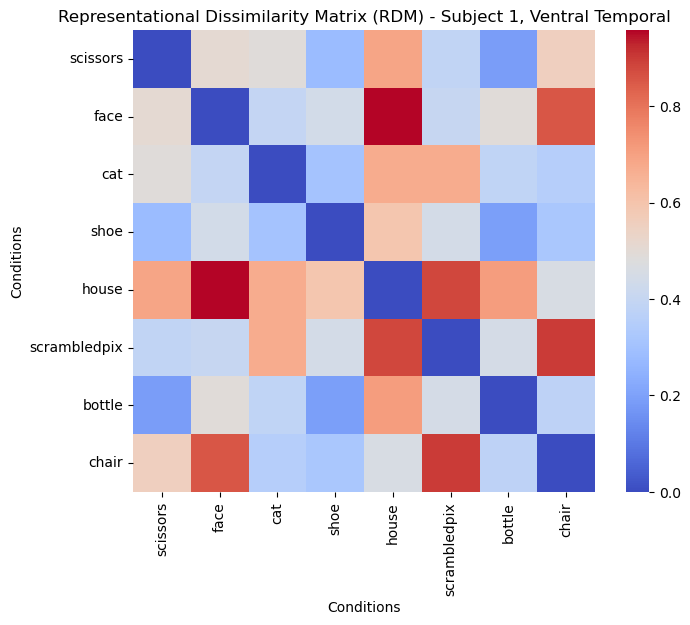

In [43]:
# Example: Extract ROI patterns and compute the RDM for the Ventral Temporal ROI
roi_patterns_vt = extract_roi_patterns(beta_maps, vt_mask, condition_indices=range(len(unique_conditions)))

# Compute the RDM
rdm_vt = compute_rdm(roi_patterns_vt)

# Visualize the RDM
visualize_rdm(rdm_vt, labels=unique_conditions, subject_id = 1, roi_name="Ventral Temporal")

### (2) Construct the RDMs, separately for each region-of-interest and for each subject. 

In [44]:
def rsa_for_subject(subject_id, roi_masks, condition_indices=None, distance_metric='correlation'):
    """
    Perform RSA for a single subject in one go:
     1) Get beta_maps via GLM
     2) For each ROI, extract patterns
     3) Compute RDM
     4) Return them 
    """

    # 1) Calculate beta maps 
    beta_maps, residuals, design_matrix = calculate_beta_maps_for_subject(subject_id)

    # 2) For each ROI: extract patterns, compute RDM
    rois_rdms = {}
    for roi_name, mask in roi_masks.items():
        #print(f"[Subject {subject_id}] Processing ROI: {roi_name} ...")
        patterns = extract_roi_patterns(beta_maps, mask, condition_indices)
        RDM = compute_rdm(patterns, metric=distance_metric)
        rois_rdms[roi_name] = RDM

    print(f"[Subject {subject_id}] Finished RSA!")
    return rois_rdms

### (3) Visualize RDMs—Which stimulus directions are emphasized? Which are de-emphasized?

In [45]:
# Calculate the RDM for subject 1 & 2
rois_rdms_subj_1 = rsa_for_subject(1, roi_masks, condition_indices=range(len(unique_conditions)))
rois_rdms_subj_2 = rsa_for_subject(2, roi_masks, condition_indices=range(len(unique_conditions)))

[Subject 1] Finished computing beta_maps!
[Subject 1] Finished RSA!
[Subject 2] Finished computing beta_maps!
[Subject 2] Finished RSA!


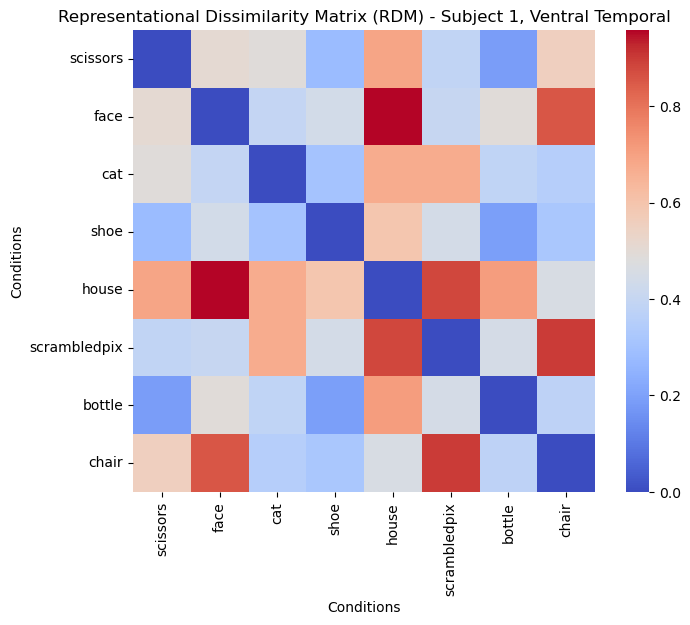

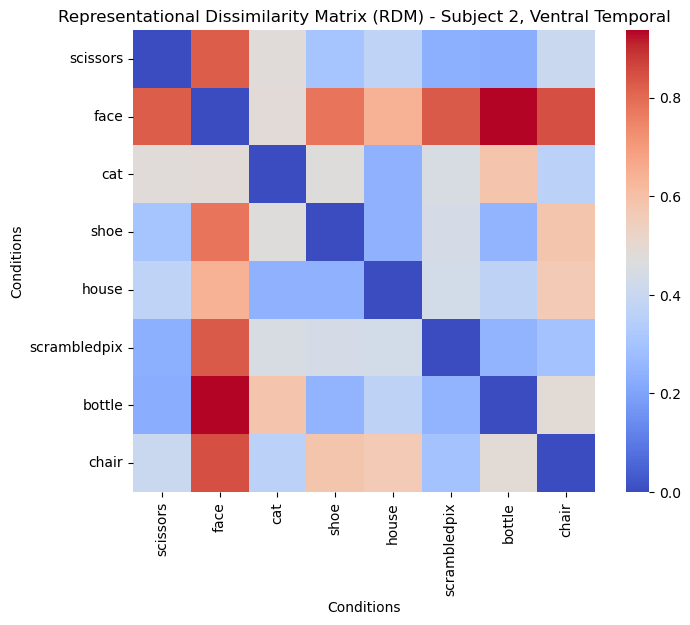

In [46]:
# Visualize the RDM for subject 1 & 2
visualize_rdm(rois_rdms_subj_1['Ventral Temporal'], labels=unique_conditions, subject_id = 1, roi_name="Ventral Temporal")
visualize_rdm(rois_rdms_subj_2['Ventral Temporal'], labels=unique_conditions, subject_id = 2, roi_name="Ventral Temporal")

In [47]:
def visualize_rdm_mds(rdm, labels=None, subject_id=None, roi_name=None, n_components=2):
    """
    Visualize an RDM using Multidimensional Scaling (MDS).
    """
    # Convert RDM to distances (MDS requires a dissimilarity matrix)
    mds = MDS(n_components=n_components, dissimilarity="precomputed", random_state=42)
    embedding = mds.fit_transform(rdm)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(labels):
        plt.scatter(embedding[i, 0], embedding[i, 1], label=label)
        plt.text(embedding[i, 0], embedding[i, 1], label, fontsize=9, ha='right', va='bottom')
    
    # Add title
    title = f"MDS of RDM - {roi_name}"
    if subject_id is not None:
        title += f" (Subject {subject_id})"
    plt.title(title)
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.grid(True)
    plt.show()

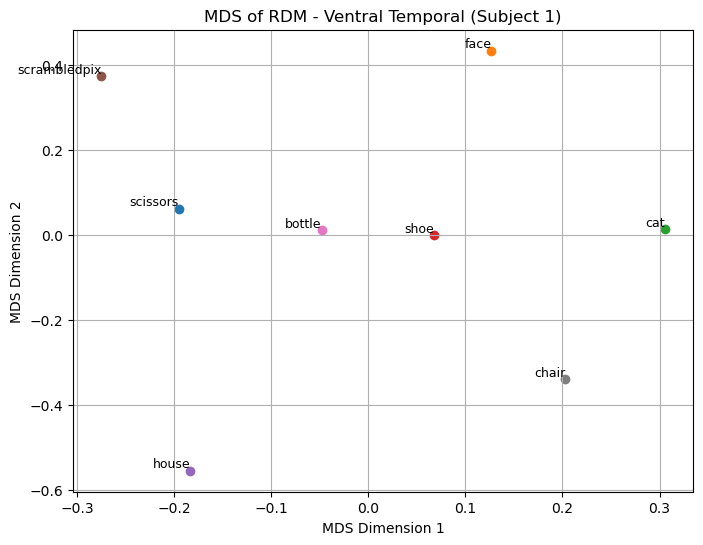

In [48]:
# Example: Ventral Temporal RDM for Subject 1
visualize_rdm_mds(
    rois_rdms_subj_1['Ventral Temporal'], 
    labels=unique_conditions, 
    subject_id=1, 
    roi_name="Ventral Temporal"
)

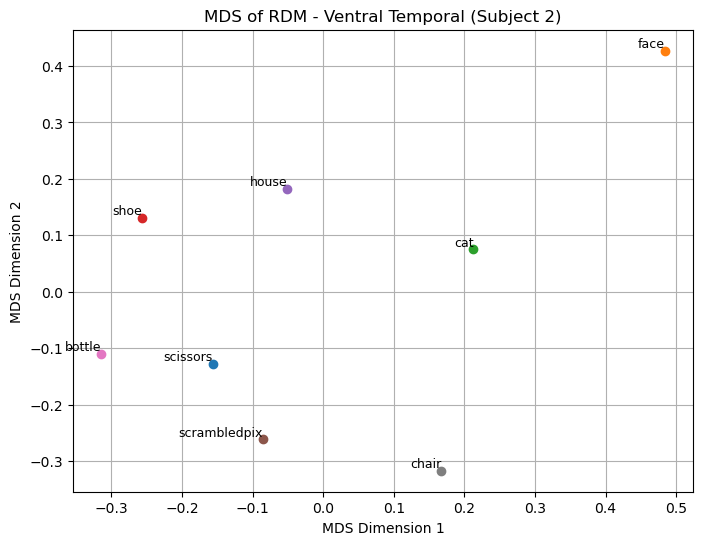

In [49]:
# Example: Ventral Temporal RDM for Subject 2
visualize_rdm_mds(
    rois_rdms_subj_2['Ventral Temporal'], 
    labels=unique_conditions, 
    subject_id=2, 
    roi_name="Ventral Temporal"
)

### (4) How similar are the RDMs across regions-of-interest and between subjects?

In [50]:
def compute_rdm_similarity(rdm1, rdm2, method="pearson"):
    """
    Compute the similarity between two RDMs (1 = identical)
    """

    # Flatten RDMs
    vec1 = squareform(rdm1)  
    vec2 = squareform(rdm2)  

    if method == "spearman":
        return spearmanr(vec1, vec2).correlation
    elif method == "pearson":
        return pearsonr(vec1, vec2)[0]
    else:
        raise ValueError("Unsupported method. Use 'spearman' or 'pearson'.")

In [51]:
def compare_rdms_across_rois_and_subjects(all_rdms, method="pearson"):
    """
    Compare RDMs across ROIs and subjects.

    Parameters
    ----------
    all_rdms : dict
        Nested dictionary: {subject_id: {roi_name: rdm}}.
    method : str, optional
        Correlation method, either "spearman" or "pearson".

    Returns
    -------
    similarity_matrix : pd.DataFrame
        Pairwise similarity between RDMs (subjects/ROIs).
    """
    
    # Flatten the dictionary into a list of (subject, roi, rdm)
    comparisons = [(subject, roi, rdm) for subject, rois in all_rdms.items() for roi, rdm in rois.items()]
    labels = [f"Subj{subject}_{roi}" for subject, roi, _ in comparisons]

    # Initialize similarity matrix
    n = len(comparisons)
    similarity_matrix = np.zeros((n, n))

    # Compute pairwise similarity
    for i, (subj1, roi1, rdm1) in enumerate(comparisons):
        for j, (subj2, roi2, rdm2) in enumerate(comparisons):
            similarity_matrix[i, j] = compute_rdm_similarity(rdm1, rdm2, method)

    # Convert to DataFrame for easier visualization
    similarity_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)
    return similarity_df

In [52]:
def construct_all_rdms(subject_ids, roi_masks, condition_indices=None, distance_metric="correlation"):
    """
    Construct all RDMs for given subjects and ROIs.

    """
    all_rdms = {}
    for subject_id in subject_ids:
        print(f"Processing Subject {subject_id} ...")
        rois_rdms = rsa_for_subject(subject_id, roi_masks, condition_indices, distance_metric)
        all_rdms[subject_id] = rois_rdms
    return all_rdms

In [53]:
def visualize_similarity_matrix(similarity_matrix, title="RDM Similarity Matrix"):
    """
    Visualize the similarity matrix as a heatmap.

    Parameters
    ----------
    similarity_matrix : pd.DataFrame
        Pairwise similarity between RDMs.
    title : str, optional
        Title of the heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=False, cmap="coolwarm", square=True)
    plt.title(title)
    plt.xlabel("RDMs")
    plt.ylabel("RDMs")
    plt.show()

In [54]:
subject_ids = [1, 2, 3, 4, 5, 6]  # List of subject IDs to process
all_rdms = construct_all_rdms(subject_ids, roi_masks)

Processing Subject 1 ...
[Subject 1] Finished computing beta_maps!
[Subject 1] Finished RSA!
Processing Subject 2 ...
[Subject 2] Finished computing beta_maps!
[Subject 2] Finished RSA!
Processing Subject 3 ...
[Subject 3] Finished computing beta_maps!
[Subject 3] Finished RSA!
Processing Subject 4 ...
[Subject 4] Finished computing beta_maps!
[Subject 4] Finished RSA!
Processing Subject 5 ...
[Subject 5] Finished computing beta_maps!
[Subject 5] Finished RSA!
Processing Subject 6 ...
[Subject 6] Finished computing beta_maps!
[Subject 6] Finished RSA!


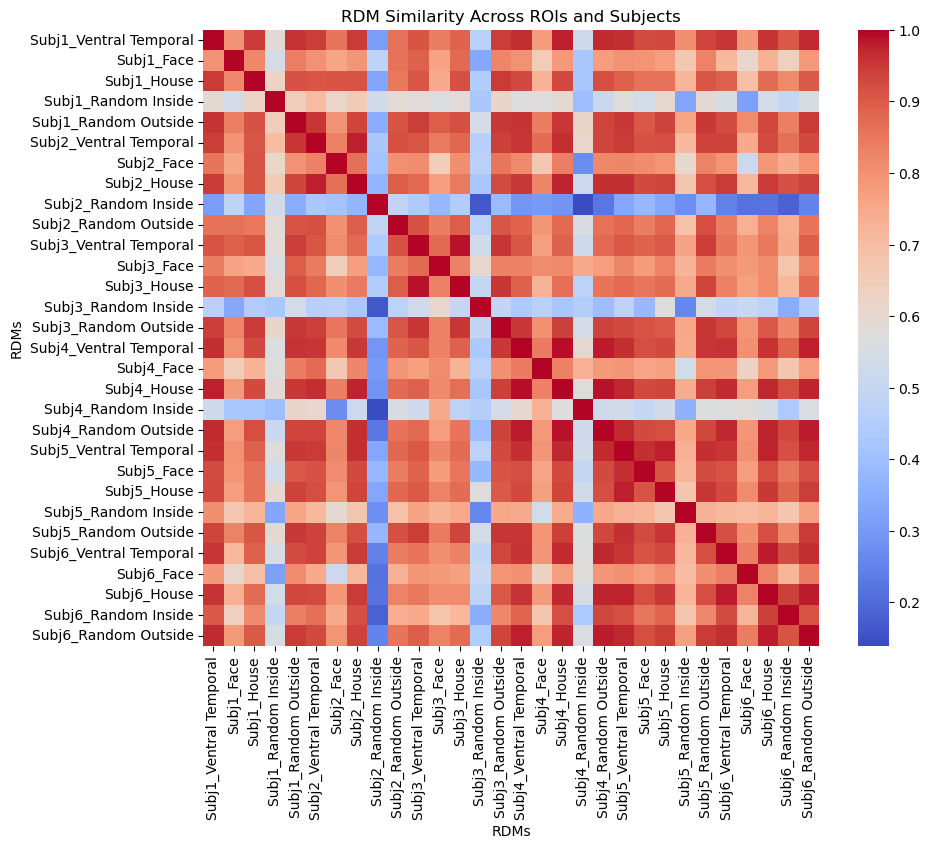

In [55]:
similarity_matrix = compare_rdms_across_rois_and_subjects(all_rdms, method="pearson")
visualize_similarity_matrix(similarity_matrix, title="RDM Similarity Across ROIs and Subjects")

In [56]:
def visualize_similarity_mds(similarity_matrix, labels=None, n_components=2):
    """
    Visualize the similarity matrix using Multidimensional Scaling (MDS).

    Parameters:
    - similarity_matrix: pd.DataFrame (RDM similarity values)
    - labels: List of labels corresponding to RDMs
    - n_components: Number of MDS dimensions (default: 2)
    """
    # Convert similarity to dissimilarity (distance = 1 - similarity)
    dissimilarity_matrix = 1 - similarity_matrix

    # Apply MDS
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42)
    embedding = mds.fit_transform(dissimilarity_matrix)

    # Plot the MDS results
    plt.figure(figsize=(16, 12))
    for i, label in enumerate(labels):
        plt.scatter(embedding[i, 0], embedding[i, 1], label=label)
        plt.text(embedding[i, 0], embedding[i, 1], label, fontsize=9, ha='right', va='bottom')

    plt.title("MDS of RDM Similarity Across ROIs and Subjects")
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.grid(True)
    plt.show()

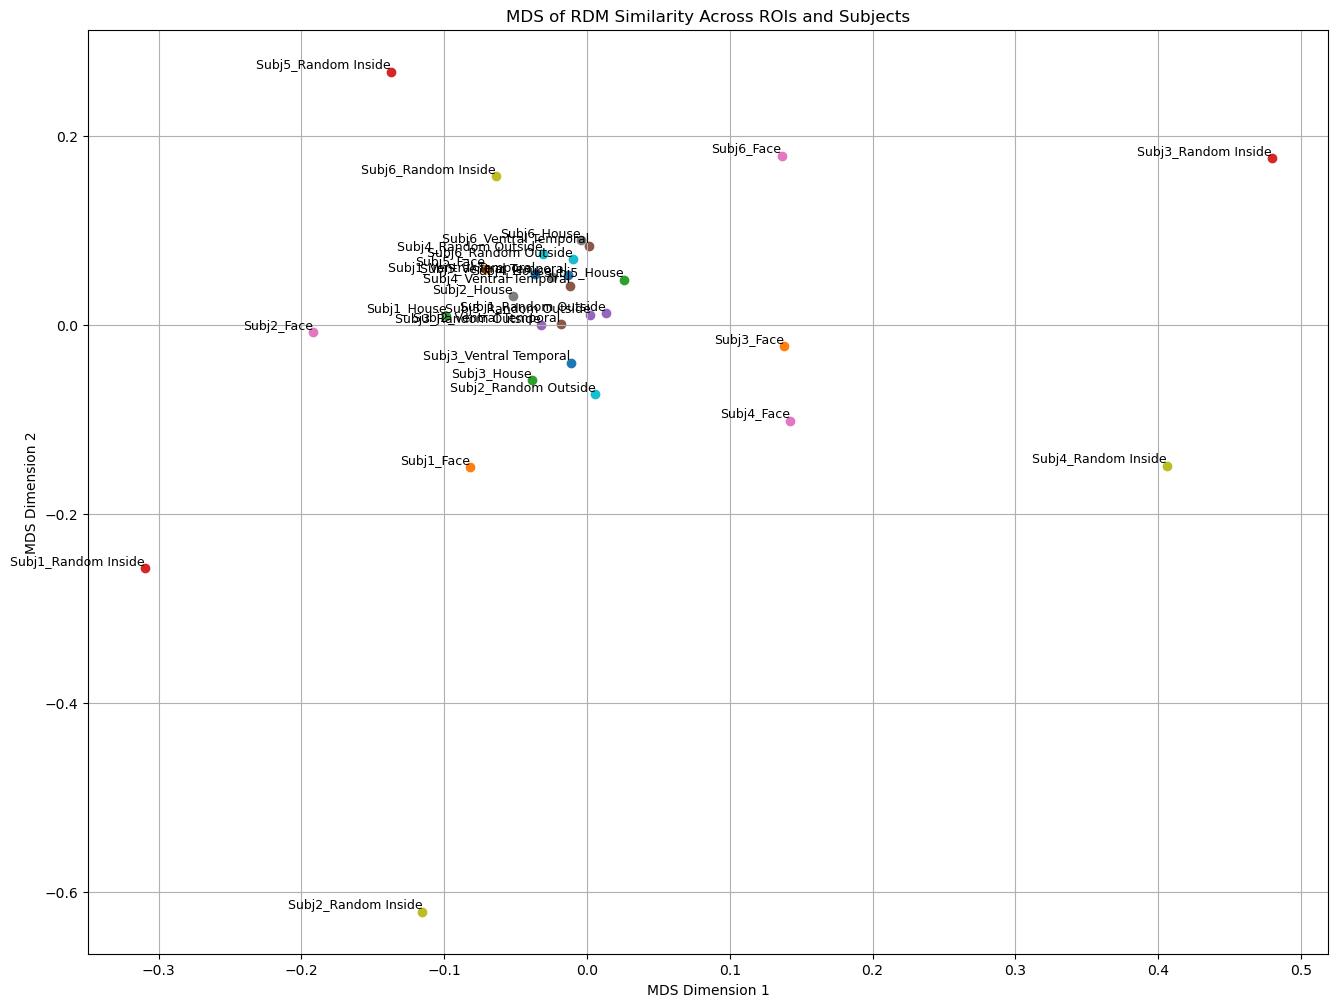

In [57]:
visualize_similarity_mds(similarity_matrix, labels=similarity_matrix.index)

In [58]:
def visualize_similarity_mds_filtered(similarity_matrix, labels=None, n_components=2):
    """
    Visualize the similarity matrix using Multidimensional Scaling (MDS),
    excluding 'Random_Inside' and 'Random_Outside' points.
    """
    
    # Identify indices to keep 
    filtered_indices = [i for i, label in enumerate(labels) if "Random Inside" not in label and "Random Outside" not in label]
    
    # Filter the similarity matrix and labels
    filtered_matrix = similarity_matrix.iloc[filtered_indices, filtered_indices]
    filtered_labels = [labels[i] for i in filtered_indices]

    # Convert similarity to dissimilarity (distance = 1 - similarity)
    dissimilarity_matrix = 1 - filtered_matrix

    # Apply MDS
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42)
    embedding = mds.fit_transform(dissimilarity_matrix)

    # Plot the MDS results
    plt.figure(figsize=(16, 12))
    for i, label in enumerate(filtered_labels):
        plt.scatter(embedding[i, 0], embedding[i, 1], s=100, alpha=0.7)  # Bigger points for better visibility
        plt.text(embedding[i, 0], embedding[i, 1], label, fontsize=12, ha='right', va='bottom')

    plt.title("MDS of RDM Similarity Across ROIs and Subjects", fontsize=16)
    plt.xlabel("MDS Dimension 1", fontsize=14)
    plt.ylabel("MDS Dimension 2", fontsize=14)
    plt.grid(True)
    plt.show()

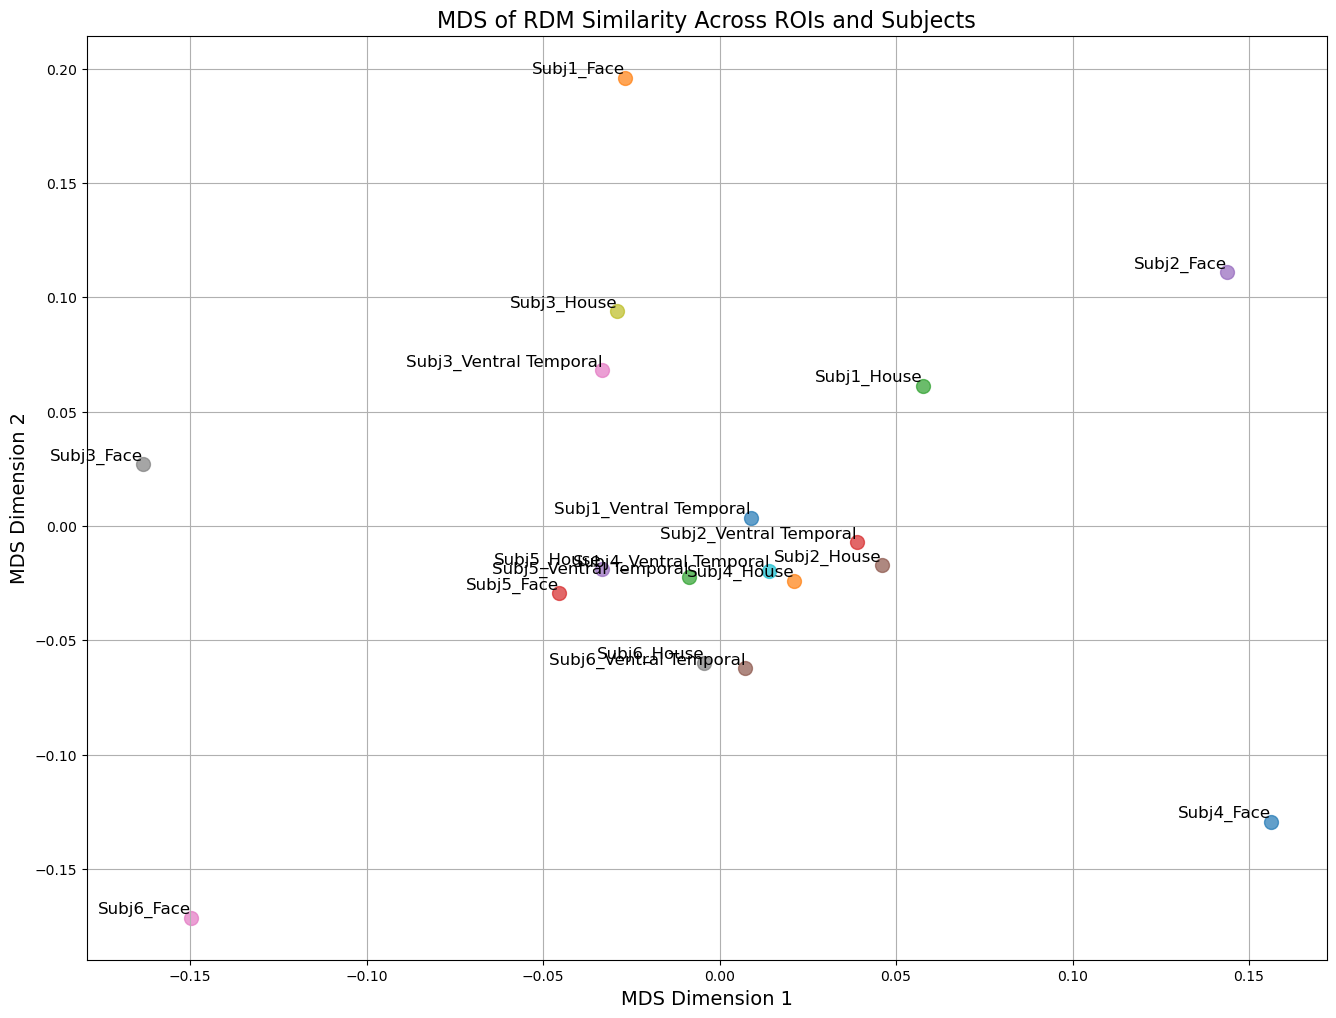

In [59]:
visualize_similarity_mds_filtered(similarity_matrix, labels=similarity_matrix.index)

### (5) If you have the data divided to training & testing datasets (related to last week’s project), you can make the split-data RDMs to (1) study the replicability of the RDMs, and/or (2) calculate the exemplar discriminability indices (EDIs).

In [60]:
def split_data_by_runs(labels, convolved_matrix, bold_data):
    """
    Splits the data into even and odd runs and ensures proper intercept handling.

    Parameters:
        labels (pd.DataFrame): DataFrame containing 'Condition' and 'Run'.
        convolved_matrix (pd.DataFrame): Full design matrix (time points × conditions + intercepts).
        bold_data (np.ndarray): BOLD fMRI data with shape (X, Y, Z, Time).

    Returns:
        dict: Dictionary with keys 'even' and 'odd', each containing:
              - "design_matrix": Split design matrix for even/odd runs (time points/2 × 14).
              - "bold_data": Corresponding split BOLD data.
    """
    # Get indices for even and odd runs
    even_indices = labels.index[labels["Run"] % 2 == 0]
    odd_indices = labels.index[labels["Run"] % 2 == 1]

    # Extract condition columns and appropriate intercepts for even runs
    even_conditions = [col for col in convolved_matrix.columns if not col.startswith("Run_")]
    even_intercepts = [f"Run_{run}" for run in labels["Run"].unique() if run % 2 == 0]
    even_columns = even_conditions + even_intercepts

    # Extract condition columns and appropriate intercepts for odd runs
    odd_conditions = [col for col in convolved_matrix.columns if not col.startswith("Run_")]
    odd_intercepts = [f"Run_{run}" for run in labels["Run"].unique() if run % 2 == 1]
    odd_columns = odd_conditions + odd_intercepts

    # Create split design matrices
    even_design_matrix = convolved_matrix.loc[even_indices, even_columns]
    odd_design_matrix = convolved_matrix.loc[odd_indices, odd_columns]

    # Split BOLD data
    even_bold_data = bold_data[..., even_indices]
    odd_bold_data = bold_data[..., odd_indices]

    # Return results
    return {
        "even": {
            "design_matrix": even_design_matrix,
            "bold_data": even_bold_data,
        },
        "odd": {
            "design_matrix": odd_design_matrix,
            "bold_data": odd_bold_data,
        },
    }

In [61]:
def compute_split_rdms(split_data, roi_masks, condition_indices=None, distance_metric="correlation"):
    """
    Compute RDMs for even and odd splits of the data.
    """
    split_rdms = {}

    for split in ["even", "odd"]:
        print(f"Processing {split} split...")
        bold_data = split_data[split]["bold_data"]
        design_matrix = split_data[split]["design_matrix"]

        # Fit GLM to compute beta maps
        residuals, beta_maps = fit_glm_and_generate_beta_maps(bold_data, design_matrix.values)

        # Compute RDMs for each ROI
        rdms = {}
        for roi_name, mask in roi_masks.items():
            patterns = extract_roi_patterns(beta_maps, mask, condition_indices)
            rdm = compute_rdm(patterns, metric=distance_metric)
            rdms[roi_name] = rdm

        split_rdms[split] = rdms

    return split_rdms

In [62]:
def compare_split_rdms(split_rdms, roi_name, method="pearson"):
    """
    Correlation between the even and odd RDMs for a specific ROI.
    """
    rdm_even = split_rdms["even"][roi_name]
    rdm_odd = split_rdms["odd"][roi_name]
    return compute_rdm_similarity(rdm_even, rdm_odd, method=method)

In [63]:
split_data = split_data_by_runs(labels, convolved_matrix, bold_data)
split_rdms = compute_split_rdms(split_data, roi_masks, condition_indices=range(len(unique_conditions)))
similarity_vt = compare_split_rdms(split_rdms, "Ventral Temporal")
print(f"Similarity between even and odd RDMs for Ventral Temporal ROI: {similarity_vt}")

Processing even split...
Processing odd split...
Similarity between even and odd RDMs for Ventral Temporal ROI: 0.3903164554007432


In [64]:
def calculate_edi(rdm_even, rdm_odd):
    """
    Calculate the Exemplar Discriminability Index (EDI).
    """
    
    # Diagonal values: Same condition across splits
    diagonal = np.diag(rdm_even) + np.diag(rdm_odd)

    # Off-diagonal values: Different conditions across splits
    off_diagonal = rdm_even[np.triu_indices_from(rdm_even, k=1)] + rdm_odd[np.triu_indices_from(rdm_odd, k=1)]

    # Calculate EDI
    edi = np.mean(off_diagonal) - np.mean(diagonal)
    return edi


In [65]:
edi_vt = calculate_edi(split_rdms["even"]["Ventral Temporal"], split_rdms["odd"]["Ventral Temporal"])
print(f"EDI for Ventral Temporal ROI: {edi_vt}")

EDI for Ventral Temporal ROI: 1.2301633460658805


In [66]:
def plot_rdm_similarity_and_edi(split_rdms, roi_masks):
    """
    Generate bar plots for RDM similarity (replicability) and EDI for different ROIs.

    Parameters
    ----------
    split_rdms : dict
        Dictionary with keys "even" and "odd", each containing ROI RDMs.
    roi_masks : dict
        Dictionary of ROI masks {roi_name: roi_mask}.
    """

    roi_names = list(roi_masks.keys())

    # Compute similarities and EDIs
    similarities = [compare_split_rdms(split_rdms, roi) for roi in roi_names]
    edi_values = [calculate_edi(split_rdms["even"][roi], split_rdms["odd"][roi]) for roi in roi_names]

    # --- Bar Plot for Similarity ---
    plt.figure(figsize=(10, 5))
    plt.bar(roi_names, similarities, color='blue', alpha=0.7)
    plt.ylabel("Spearman Similarity")
    plt.title("RDM Similarity Across Splits (Even vs. Odd)")
    plt.ylim([-1, 1])  # Set y-axis limits (0 = no similarity, 1 = perfect similarity)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- Bar Plot for EDI ---
    plt.figure(figsize=(10, 5))
    plt.bar(roi_names, edi_values, color='red', alpha=0.7)
    plt.ylabel("Exemplar Discriminability Index (EDI)")
    plt.title("EDI Across ROIs")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


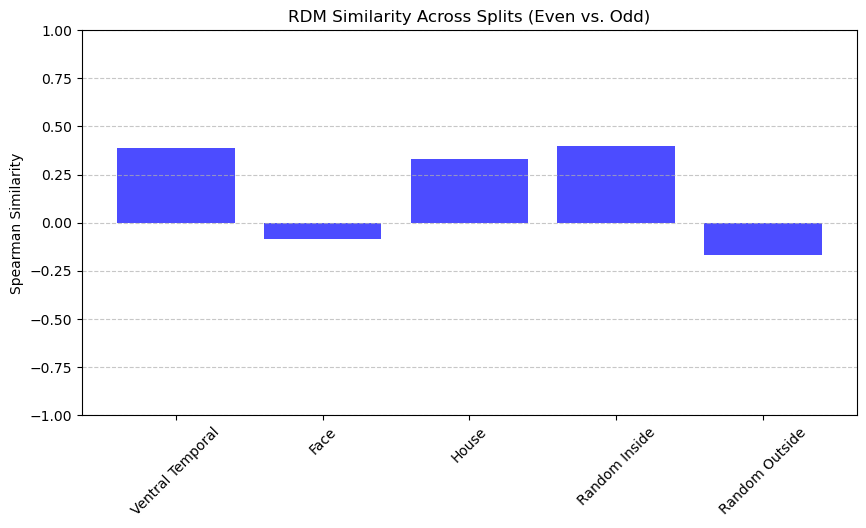

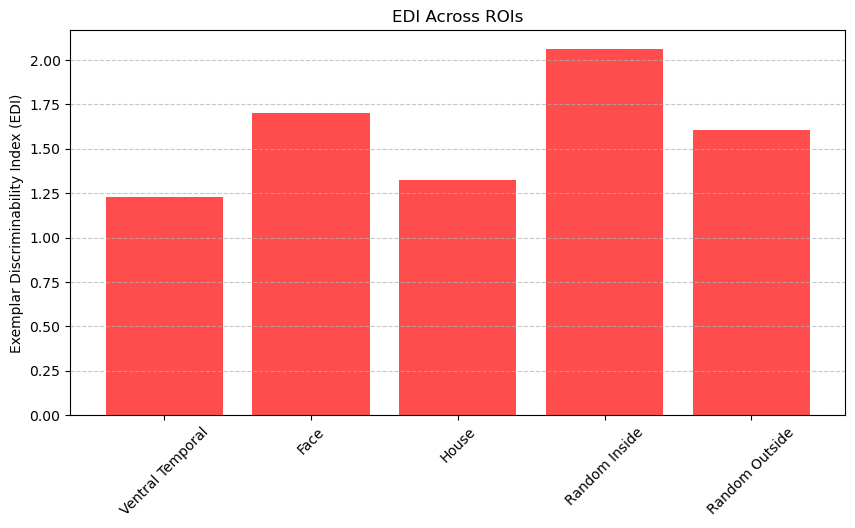

In [67]:
plot_rdm_similarity_and_edi(split_rdms, roi_masks)

### Project Work Bonus: vRF modeling of fMRI data

- How would you start implementing a voxel receptive field model?
- The Haxby data is not optimal for vRF fitting. Why?

In [68]:
import os
import cv2
import pywt
from scipy.signal import convolve

In [69]:
def extract_wavelet_features(image, wavelet='haar', level=2):
    """
    Extract wavelet features from an image.
    """
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    features = []

    for coeff in coeffs:
        if isinstance(coeff, tuple):
            # Detail coefficients (horizontal, vertical, diagonal)
            for c in coeff:
                features.append(np.mean(c))
                features.append(np.std(c))
        else:
            # Approximation coefficients
            features.append(np.mean(coeff))
            features.append(np.std(coeff))

    return np.array(features)

In [70]:
def load_and_extract_wavelet_features(stimuli_folder, wavelet='haar', level=2):
    """
    Load all images from the stimuli folder and extract Wavelet features.
    """
    
    all_features = []
    categories = [d for d in os.listdir(stimuli_folder) if os.path.isdir(os.path.join(stimuli_folder, d))]

    for category in categories:
        category_path = os.path.join(stimuli_folder, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)

            if not os.path.isfile(file_path):
                continue

            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            
            if image is None:
                print(f"Warning: Failed to load image {file_path}")
                continue

            # Normalize
            image = image / 255.0
            features = extract_wavelet_features(image, wavelet, level)
            all_features.append(features)

    return np.array(all_features)

In [71]:
# Apply wavelet feature extraction
stimuli_folder = "stimuli"
wavelet_features = load_and_extract_wavelet_features(stimuli_folder)

print(f"Extracted wavelet features shape: {wavelet_features.shape}") 

Extracted wavelet features shape: (335, 14)


In [72]:
# Count occurrences of each condition in the labels file
condition_counts = labels["Condition"].value_counts()
print(condition_counts)

Condition
rest            588
scissors        108
face            108
cat             108
shoe            108
house           108
scrambledpix    108
bottle          108
chair           108
Name: count, dtype: int64


In [73]:
stimuli_folder = "stimuli"
controls_folder = os.path.join(stimuli_folder, "controls")

# Count total images
stimuli_count = sum([len(files) for _, _, files in os.walk(stimuli_folder) if "controls" not in _])
controls_count = sum([len(files) for _, _, files in os.walk(controls_folder)])

print(f"Total images in stimuli : {stimuli_count}")
print(f"Total images in controls: {controls_count}")

Total images in stimuli : 663
Total images in controls: 328


In [74]:
# Convolve Gabor features with HRF
def convolve_with_hrf(features, hrf):
    """
    Convolve features with the HRF.
    Args:
        features (numpy.ndarray): Design matrix (rows = images, cols = Gabor features).
        hrf (numpy.ndarray): Hemodynamic Response Function.
    Returns:
        convolved_features (numpy.ndarray): Convolved design matrix.
    """
    convolved_features = np.zeros_like(features)
    for col in range(features.shape[1]):  # Convolve each feature column
        convolved_features[:, col] = convolve(features[:, col], hrf, mode='full')[:features.shape[0]]
    return convolved_features

In [75]:
# Apply HRF convolution
convolved_design_matrix = convolve_with_hrf(wavelet_features, hrf_sampled)
print(f"Convolved design matrix shape: {convolved_design_matrix.shape}")  # Expected: (1452, 16)

Convolved design matrix shape: (335, 14)


In [76]:
def fit_vrf_model(voxel_data, design_matrix):
    beta_weights = np.linalg.pinv(design_matrix.T @ design_matrix) @ design_matrix.T @ voxel_data
    return beta_weights

In [77]:
# Extract voxel data from the ventral temporal ROI
vt_voxel_data = bold_data[vt_mask]  # Shape: (577, 1452)

# Fit the vRF Model
beta_weights = fit_vrf_model(vt_voxel_data.T, convolved_design_matrix)

print(f"Fitted vRF model. Beta weights shape: {beta_weights.shape}") 

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1452 is different from 335)